# Movie recommendation on Amazon SageMaker with Factorization Machines
Reference: https://aws.amazon.com/blogs/machine-learning/build-a-movie-recommender-with-factorization-machines-on-amazon-sagemaker/

# Introduction

## Factorization Machines

- Factorization Machines (FM) are a supervised machine learning technique introduced in 2010 (https://www.csie.ntu.edu.tw/~b97053/paper/Rendle2010FM.pdf). FM get their name from their ability to reduce problem dimensionality thanks to matrix factorization.
- Factorization machines can be used for classification or regression and are much more computationally efficient on large sparse data sets than traditional algorithms like linear regression. This property is why FM are widely used for recommendation. User count and item count are typically very large although the actual number of recommendations is very small (users don’t rate all available items!).

## The MovieLens dataset
- The MovieLens dataset: https://grouplens.org/datasets/movielens/
- ml100k: 100,000 ratings from 943 users on 1682 movies.
- The ml100k rating matrix is quite sparse (93.6% to be precise) because it only holds 100,000 ratings out of a possible 1,586,126 (943*1682).

## Data set preparation
- FM work best on high-dimension datasets. As a consequence, we’re going to one-hot encode user IDs and movie IDs (we’ll ignore timestamps). Thus, each sample in our data set will be a 2,625 Boolean vector (943+1682) with only two values set to 1 with respect to the user ID and movie ID.
- one-hot encoding: https://www.quora.com/What-is-one-hot-encoding-and-when-is-it-used-in-data-science

- We’re going to build a binary recommender (that is, like/don’t like). 4-star and 5-star ratings are set to 1. Lower ratings are set to 0.
- One last thing: the FM implementation in Amazon SageMaker requires training and test data to be stored in float32 tensors in protobuf format. (Yes, that sounds complicated 🙂 However, the Amazon SageMaker SDK provides a convenient utility function that takes cares of this, so don’t worry too much about it.

## The high-level view
Here are the steps you will implement:

1. Load the MovieLens training set and test set from disk.
2. For each set, build a sparse matrix holding one-hot encoded data samples.
3. For each set, build a label vector holding ratings.
4. Write both sets to protobuf-encoded files.
5. Copy these files to an Amazon S3 bucket.
6. Configure and run a factorization machines training job on Amazon SageMaker.
7. Deploy the corresponding model to an endpoint.
8. Run some predictions.

### Download ml-100k dataset

- The MovieLens dataset: https://grouplens.org/datasets/movielens/
- ml100k: 100,000 ratings from 943 users on 1682 movies.
- The ml100k rating matrix is quite sparse (93.6% to be precise) because  it only holds 100,000 ratings out of a possible 1,586,126 (943*1682).

In [1]:
!wget http://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip -o ml-100k.zip

--2018-08-29 16:00:04--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.34.235
Connecting to files.grouplens.org (files.grouplens.org)|128.101.34.235|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  20.2MB/s    in 0.2s    

2018-08-29 16:00:04 (20.2 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base

### Random display first 10 lines in the data set: user 279 gave movie 1244 a 3-star rating, and so on.

In [2]:
%cd ml-100k
!shuf ua.base -o ua.base.shuffled
!head -10 ua.base.shuffled

/home/ec2-user/SageMaker/ml-100k
279	1244	3	875298652
897	510	3	879990531
829	475	4	891990718
771	111	4	880659919
295	402	5	879518820
883	226	3	892557605
312	493	5	891698365
399	69	3	882342019
921	276	1	879381004
339	506	4	891033766


### Display first 10 lines in the data set.

In [3]:
!head -10 ua.test

1	20	4	887431883
1	33	4	878542699
1	61	4	878542420
1	117	3	874965739
1	155	2	878542201
1	160	4	875072547
1	171	5	889751711
1	189	3	888732928
1	202	5	875072442
1	265	4	878542441


In [43]:
import pandas as pd
data = pd.read_csv("ua.base", sep='\t', header=None, names=['userid', 'movieid', 'rating', 'timestamp'])
print "Number of Users: %d" % (data['userid'].max())
print "Number of Movies: %d" % (data['movieid'].max())

Number of Users: 943
Number of Movies: 1682


AxesSubplot(0.125,0.125;0.775x0.755)


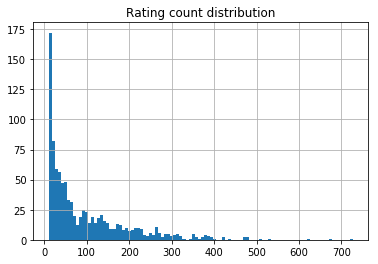

In [48]:
movies_by_user = data.groupby('userid')
res = movies_by_user['movieid'].count().hist(bins=100)
res.set_title('Rating count distribution')
print res

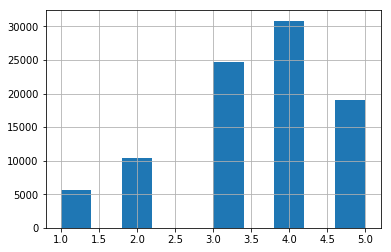

In [46]:
data['rating'].hist()

In [4]:
import sagemaker
import sagemaker.amazon.common as smac
from sagemaker import get_execution_role
from sagemaker.predictor import json_deserializer

import boto3, csv, io, json
import numpy as np
from scipy.sparse import lil_matrix

### Build training set and test set

In [5]:
nbUsers=943
nbMovies=1682
nbFeatures=nbUsers+nbMovies

nbRatingsTrain=90570
nbRatingsTest=9430

In [24]:
# For each user, build a list of rated movies.
# We'd need this to add random negative samples.
moviesByUser = {}
for userId in range(nbUsers):
    moviesByUser[str(userId)]=[]
#print moviesByUser
 
with open('ua.base.shuffled','r') as f:
    samples=csv.reader(f,delimiter='\t')
    for userId,movieId,rating,timestamp in samples:
        moviesByUser[str(int(userId)-1)].append(int(movieId)-1)
        
#print moviesByUser

### Generate sparse matrx by source datasets

In [7]:
def loadDataset(filename, lines, columns):
    # Features are one-hot encoded in a sparse matrix
    X = lil_matrix((lines, columns)).astype('float32')
    # Labels are stored in a vector
    Y = []
    line=0
    with open(filename,'r') as f:
        samples=csv.reader(f,delimiter='\t')
        for userId,movieId,rating,timestamp in samples:
            X[line,int(userId)-1] = 1
            X[line,int(nbUsers)+int(movieId)-1] = 1
            if int(rating) >= 4:
                Y.append(1)
            else:
                Y.append(0)
            line=line+1
            
    Y=np.array(Y).astype('float32')
    return X,Y

In [35]:
X_train, Y_train = loadDataset('ua.base.shuffled', nbRatingsTrain, nbFeatures)
X_test, Y_test = loadDataset('ua.test',nbRatingsTest,nbFeatures)

In [9]:
print(X_train.shape)
print(Y_train.shape)
assert X_train.shape == (nbRatingsTrain, nbFeatures)
assert Y_train.shape == (nbRatingsTrain, )
zero_labels = np.count_nonzero(Y_train)
print("Training labels: %d zeros, %d ones" % (zero_labels, nbRatingsTrain-zero_labels))

print(X_test.shape)
print(Y_test.shape)
assert X_test.shape  == (nbRatingsTest, nbFeatures)
assert Y_test.shape  == (nbRatingsTest, )
zero_labels = np.count_nonzero(Y_test)
print("Test labels: %d zeros, %d ones" % (zero_labels, nbRatingsTest-zero_labels))

(90570, 2625)
(90570,)
Training labels: 49906 zeros, 40664 ones
(9430, 2625)
(9430,)
Test labels: 5469 zeros, 3961 ones


### Convert to protobuf and save to S3

In [49]:
bucket = '<YOUR S3 BUCKET NAME. Include sagemaker in the bucket name>'
prefix = 'sagemaker/fm-movielens'

train_key      = 'train.protobuf'
train_prefix   = '{}/{}'.format(prefix, 'train3')

test_key       = 'test.protobuf'
test_prefix    = '{}/{}'.format(prefix, 'test3')

output_prefix  = 's3://{}/{}/output'.format(bucket, prefix)

In [13]:
def writeDatasetToProtobuf(X, Y, bucket, prefix, key):
    buf = io.BytesIO()
    smac.write_spmatrix_to_sparse_tensor(buf, X, Y)
    buf.seek(0)
    obj = '{}/{}'.format(prefix, key)
    boto3.resource('s3').Bucket(bucket).Object(obj).upload_fileobj(buf)
    return 's3://{}/{}'.format(bucket,obj)
    
train_data = writeDatasetToProtobuf(X_train, Y_train, bucket, train_prefix, train_key)    
test_data  = writeDatasetToProtobuf(X_test, Y_test, bucket, test_prefix, test_key) 

  
print(train_data)
print(test_data)
print('Output: {}'.format(output_prefix))

s3://sagemaker-20180831-demo/sagemaker/fm-movielens/train3/train.protobuf
s3://sagemaker-20180831-demo/sagemaker/fm-movielens/test3/test.protobuf
Output: s3://sagemaker-20180831-demo/sagemaker/fm-movielens/output


### Run training job

Training Image and Inference Image Registry Path: https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-algo-docker-registry-paths.html

In [14]:
containers = {'us-west-2': '174872318107.dkr.ecr.us-west-2.amazonaws.com/factorization-machines:latest',
              'us-east-1': '382416733822.dkr.ecr.us-east-1.amazonaws.com/factorization-machines:latest',
              'us-east-2': '404615174143.dkr.ecr.us-east-2.amazonaws.com/factorization-machines:latest',
              'eu-west-1': '438346466558.dkr.ecr.eu-west-1.amazonaws.com/factorization-machines:latest'}

### Factorization Machines Hyperparameters
https://docs.aws.amazon.com/sagemaker/latest/dg/fact-machines-hyperparameters.html

In [15]:
fm = sagemaker.estimator.Estimator(containers[boto3.Session().region_name],
                                   get_execution_role(), 
                                   train_instance_count=1, 
                                   train_instance_type='ml.c4.xlarge',
                                   output_path=output_prefix,
                                   sagemaker_session=sagemaker.Session())

fm.set_hyperparameters(feature_dim=nbFeatures,
                      predictor_type='binary_classifier',
                      mini_batch_size=1000,
                      num_factors=64,
                      epochs=100)

fm.fit({'train': train_data, 'test': test_data})

INFO:sagemaker:Creating training-job with name: factorization-machines-2018-08-29-16-03-26-066


.....................
Docker entrypoint called with argument(s): train
[08/29/2018 16:06:47 INFO 139900944955200] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'factors_lr': u'0.0001', u'linear_init_sigma': u'0.01', u'epochs': 1, u'_wd': u'1.0', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'factors_init_sigma': u'0.001', u'_log_level': u'info', u'bias_init_method': u'normal', u'linear_init_method': u'normal', u'linear_lr': u'0.001', u'factors_init_method': u'normal', u'_tuning_objective_metric': u'', u'bias_wd': u'0.01', u'use_linear': u'true', u'bias_lr': u'0.1', u'mini_batch_size': u'1000', u'_use_full_symbolic': u'true', u'batch_metrics_publish_interval': u'500', u'bias_init_sigma': u'0.01', u'_num_gpus': u'auto', u'_data_format': u'record', u'factors_wd': u'0.00001', u'linear_wd': u'0.001', u'_kvstore': u'auto', u'_learning_rate': u'1.0', u'_optimizer': u'adam'}
[08/29/2018 16:06:47 INFO 139900944955200] R

[08/29/2018 16:06:54 INFO 139900944955200] #quality_metric: host=algo-1, epoch=8, train binary_classification_accuracy <score>=0.702307692308
[08/29/2018 16:06:54 INFO 139900944955200] #quality_metric: host=algo-1, epoch=8, train binary_classification_cross_entropy <loss>=0.619893446702
[08/29/2018 16:06:54 INFO 139900944955200] #quality_metric: host=algo-1, epoch=8, train binary_f_1.000 <score>=0.762813665575
#metrics {"Metrics": {"update.time": {"count": 1, "max": 724.3208885192871, "sum": 724.3208885192871, "min": 724.3208885192871}}, "EndTime": 1535558814.371997, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "factorization-machines"}, "StartTime": 1535558813.647233}

[08/29/2018 16:06:54 INFO 139900944955200] #progress_metric: host=algo-1, completed 9 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 91, "sum": 91.0, "min": 91}, "Number of Batches Since Last Reset": {"count": 1, "max": 91, "sum": 91.0, "min": 91}, "Num

[08/29/2018 16:07:03 INFO 139900944955200] #quality_metric: host=algo-1, epoch=21, train binary_classification_accuracy <score>=0.728483516484
[08/29/2018 16:07:03 INFO 139900944955200] #quality_metric: host=algo-1, epoch=21, train binary_classification_cross_entropy <loss>=0.573025287335
[08/29/2018 16:07:03 INFO 139900944955200] #quality_metric: host=algo-1, epoch=21, train binary_f_1.000 <score>=0.767986928841
#metrics {"Metrics": {"update.time": {"count": 1, "max": 757.6451301574707, "sum": 757.6451301574707, "min": 757.6451301574707}}, "EndTime": 1535558823.888072, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "factorization-machines"}, "StartTime": 1535558823.129997}

[08/29/2018 16:07:03 INFO 139900944955200] #progress_metric: host=algo-1, completed 22 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 91, "sum": 91.0, "min": 91}, "Number of Batches Since Last Reset": {"count": 1, "max": 91, "sum": 91.0, "min": 91}, 

[08/29/2018 16:07:13 INFO 139900944955200] #quality_metric: host=algo-1, epoch=35, train binary_classification_accuracy <score>=0.739461538462
[08/29/2018 16:07:13 INFO 139900944955200] #quality_metric: host=algo-1, epoch=35, train binary_classification_cross_entropy <loss>=0.550846839318
[08/29/2018 16:07:13 INFO 139900944955200] #quality_metric: host=algo-1, epoch=35, train binary_f_1.000 <score>=0.772525353315
#metrics {"Metrics": {"update.time": {"count": 1, "max": 678.0781745910645, "sum": 678.0781745910645, "min": 678.0781745910645}}, "EndTime": 1535558833.938026, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "factorization-machines"}, "StartTime": 1535558833.259502}

[08/29/2018 16:07:13 INFO 139900944955200] #progress_metric: host=algo-1, completed 36 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 91, "sum": 91.0, "min": 91}, "Number of Batches Since Last Reset": {"count": 1, "max": 91, "sum": 91.0, "min": 91}, 

[08/29/2018 16:07:23 INFO 139900944955200] #quality_metric: host=algo-1, epoch=49, train binary_classification_accuracy <score>=0.742659340659
[08/29/2018 16:07:23 INFO 139900944955200] #quality_metric: host=algo-1, epoch=49, train binary_classification_cross_entropy <loss>=0.537679658659
[08/29/2018 16:07:23 INFO 139900944955200] #quality_metric: host=algo-1, epoch=49, train binary_f_1.000 <score>=0.774005520063
#metrics {"Metrics": {"update.time": {"count": 1, "max": 709.9301815032959, "sum": 709.9301815032959, "min": 709.9301815032959}}, "EndTime": 1535558843.862774, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "factorization-machines"}, "StartTime": 1535558843.152311}

[08/29/2018 16:07:23 INFO 139900944955200] #progress_metric: host=algo-1, completed 50 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 91, "sum": 91.0, "min": 91}, "Number of Batches Since Last Reset": {"count": 1, "max": 91, "sum": 91.0, "min": 91}, 

[08/29/2018 16:07:33 INFO 139900944955200] #quality_metric: host=algo-1, epoch=63, train binary_classification_accuracy <score>=0.745285714286
[08/29/2018 16:07:33 INFO 139900944955200] #quality_metric: host=algo-1, epoch=63, train binary_classification_cross_entropy <loss>=0.528661732768
[08/29/2018 16:07:33 INFO 139900944955200] #quality_metric: host=algo-1, epoch=63, train binary_f_1.000 <score>=0.775742799369
#metrics {"Metrics": {"update.time": {"count": 1, "max": 717.9269790649414, "sum": 717.9269790649414, "min": 717.9269790649414}}, "EndTime": 1535558853.907576, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "factorization-machines"}, "StartTime": 1535558853.189129}

[08/29/2018 16:07:33 INFO 139900944955200] #progress_metric: host=algo-1, completed 64 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 91, "sum": 91.0, "min": 91}, "Number of Batches Since Last Reset": {"count": 1, "max": 91, "sum": 91.0, "min": 91}, 

[08/29/2018 16:07:44 INFO 139900944955200] #quality_metric: host=algo-1, epoch=77, train binary_classification_accuracy <score>=0.746736263736
[08/29/2018 16:07:44 INFO 139900944955200] #quality_metric: host=algo-1, epoch=77, train binary_classification_cross_entropy <loss>=0.522019304213
[08/29/2018 16:07:44 INFO 139900944955200] #quality_metric: host=algo-1, epoch=77, train binary_f_1.000 <score>=0.776790989124
#metrics {"Metrics": {"update.time": {"count": 1, "max": 751.4758110046387, "sum": 751.4758110046387, "min": 751.4758110046387}}, "EndTime": 1535558864.209703, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "factorization-machines"}, "StartTime": 1535558863.457782}

[08/29/2018 16:07:44 INFO 139900944955200] #progress_metric: host=algo-1, completed 78 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 91, "sum": 91.0, "min": 91}, "Number of Batches Since Last Reset": {"count": 1, "max": 91, "sum": 91.0, "min": 91}, 

[08/29/2018 16:07:53 INFO 139900944955200] #quality_metric: host=algo-1, epoch=90, train binary_classification_accuracy <score>=0.748164835165
[08/29/2018 16:07:53 INFO 139900944955200] #quality_metric: host=algo-1, epoch=90, train binary_classification_cross_entropy <loss>=0.517081477909
[08/29/2018 16:07:53 INFO 139900944955200] #quality_metric: host=algo-1, epoch=90, train binary_f_1.000 <score>=0.778011333366
#metrics {"Metrics": {"update.time": {"count": 1, "max": 806.3538074493408, "sum": 806.3538074493408, "min": 806.3538074493408}}, "EndTime": 1535558873.833769, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "factorization-machines"}, "StartTime": 1535558873.026922}

[08/29/2018 16:07:53 INFO 139900944955200] #progress_metric: host=algo-1, completed 91 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 91, "sum": 91.0, "min": 91}, "Number of Batches Since Last Reset": {"count": 1, "max": 91, "sum": 91.0, "min": 91}, 

===== Job Complete =====
Billable seconds: 183


### Deploy model

In [17]:
fm_predictor = fm.deploy(instance_type='ml.c4.xlarge', initial_instance_count=1)

INFO:sagemaker:Creating model with name: factorization-machines-2018-08-29-16-16-35-491
INFO:sagemaker:Creating endpoint with name factorization-machines-2018-08-29-16-03-26-066


-----------------------------------------------------------------------------!

In [18]:
def fm_serializer(data):
    js = {'instances': []}
    for row in data:
        js['instances'].append({'features': row.tolist()})
    #print js
    return json.dumps(js)

fm_predictor.content_type = 'application/json'
fm_predictor.serializer = fm_serializer
fm_predictor.deserializer = json_deserializer

### Run predictions

Factorization Machine Response Formats: https://docs.aws.amazon.com/sagemaker/latest/dg/fm-in-formats.html

In [39]:
result = fm_predictor.predict(X_test[1000:1010].toarray())
print(result)
print(X_test[1000:1010])
print (Y_test[1000:1010])

{u'predictions': [{u'score': 0.6766509413719177, u'predicted_label': 1.0}, {u'score': 0.19074834883213043, u'predicted_label': 0.0}, {u'score': 0.22185929119586945, u'predicted_label': 0.0}, {u'score': 0.6023930907249451, u'predicted_label': 1.0}, {u'score': 0.5216781497001648, u'predicted_label': 1.0}, {u'score': 0.14504921436309814, u'predicted_label': 0.0}, {u'score': 0.3809090554714203, u'predicted_label': 0.0}, {u'score': 0.4980613887310028, u'predicted_label': 0.0}, {u'score': 0.3402355909347534, u'predicted_label': 0.0}, {u'score': 0.11507865786552429, u'predicted_label': 0.0}]}
  (0, 100)	1.0
  (0, 1164)	1.0
  (1, 100)	1.0
  (1, 1194)	1.0
  (2, 100)	1.0
  (2, 1223)	1.0
  (3, 100)	1.0
  (3, 1224)	1.0
  (4, 100)	1.0
  (4, 1246)	1.0
  (5, 100)	1.0
  (5, 1311)	1.0
  (6, 100)	1.0
  (6, 1347)	1.0
  (7, 100)	1.0
  (7, 1413)	1.0
  (8, 100)	1.0
  (8, 1538)	1.0
  (9, 100)	1.0
  (9, 1771)	1.0
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
